# Data Analysis with Jupyter

As described in the previous module, we can view the automated experiment output from the VM resource log files.
In this module, we will use the JSON-formatted files to begin to analyze the data (i.e., the latency of getting the web page).
As there is only one client, the initial data will be uninteresting, but the following modules will add complexity
and build on this experiment to enable more interesting data analysis.

In this module, you will use standard Python-based data science tools including [Jupyter](https://jupyter.org/), [pandas](https://pandas.pydata.org/),  [seaborn](https://seaborn.pydata.org/), and [Matplotlib](https://matplotlib.org/) and learn how to assess experiment data with them.
This module is simply an example of how experiment data can be analyzed and there are numerous other tools to do so (e.g., Elasticsearch/Kibana).
While we strive to provide comments explaining what each section of code is accomplishing in-depth discussion/tutorials about these tools is outside the scope of this module.

First we will install [Jupyter](https://jupyter.org/), [pandas](https://pandas.pydata.org/),  [seaborn](https://seaborn.pydata.org/), and [Matplotlib](https://matplotlib.org/) into our Python virtual environment.

```bash
$ source /opt/firewheel/fwpy/bin/activate
$ python -m pip install jupyter pandas seaborn matplotlib
```


## Opening Jupyter
Once installed, you can start Jupyter by running `jupyter-notebook`, which will result in similar output:

```bash 
$ jupyter-notebook
[I 2024-06-03 09:57:15.026 ServerApp] jupyter_lsp | extension was successfully linked.
[I 2024-06-03 09:57:15.031 ServerApp] jupyter_server_terminals | extension was successfully linked.
[I 2024-06-03 09:57:15.037 ServerApp] jupyterlab | extension was successfully linked.
[I 2024-06-03 09:57:15.042 ServerApp] notebook | extension was successfully linked.
...
[I 2024-06-03 09:57:15.346 ServerApp] Jupyter Server 2.14.1 is running at:
[I 2024-06-03 09:57:15.346 ServerApp] http://localhost:8888/tree?token=d68f967dfce80a2f0e4204452ff13046275d75ea420ad0b2
[I 2024-06-03 09:57:15.346 ServerApp]     http://127.0.0.1:8888/tree?token=d68f967dfce80a2f0e4204452ff13046275d75ea420ad0b2
[I 2024-06-03 09:57:15.346 ServerApp] Use Control-C to stop this server and shut down all kernels (twice to skip confirmation).
```

**Important:** Take note of the lines with the URL/token as that will be used to access the notebook.

Depending on how your cluster is configured, Jupyter will likely be running on ``http://localhost:8888``.
If you had to port-forward your miniweb dashboard, you will need to do the same for Jupyter (e.g., ``ssh -Llocalhost:8888:localhost:8888 <node>``).

Now we can access the notebook via the link provided in the `jupyter-notebook` output (e.g., ``http://localhost:8888/tree?token=d68f...``).

Create a new notebook and add the following import statements.

In [1]:
import glob  # noqa: F401
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from firewheel.config import Config

## Getting the Right Path

First we need to identify where the VM resource logs are located. This was described in the previous module, but it can easily be programmatically identified by accessing FIREWHEEL configuration and concatenating the `logging.root_dir` parameter with the `logging.vmr_log_dir` parameter. As a reminder, an example of the `logging` subsection of the configuration is provided below:

```yaml
logging:
    cli_log: cli.log
    discovery_log: discovery.log
    firewheel_log: firewheel.log
    level: DEBUG
    minimega_log: minimega.log
    root_dir: /scratch/
    vmr_log_dir: vm_resource_logs
```

In [2]:
# First we should identify the VM resource logging directory
fw_config = Config().config

# Get the full path to the VM resource logs
vm_resource_log_path = Path(fw_config["logging"]["root_dir"]) / Path(
    fw_config["logging"]["vmr_log_dir"]
)

In [3]:
# Now we should get all the client data

# USE THIS LINE FOR THE SINGLE CLIENT EXPERIMENT
paths = vm_resource_log_path.glob("Client.json")  # For the single client case

# USE THIS LINE FOR THE MULTI-CLIENT EXPERIMENT
# paths = vm_resource_log_path.glob(
#     "client-*.json"
# )  # When we add complexity in later modules.


# We can use an empty list to store a single dataframe per VM resource log
dfs = []
for file in paths:
    # Read the line-delienated JSON data
    data = pd.read_json(file, lines=True)

    # Add Client Name
    data["client"] = file.stem

    # Append the data frame to the list
    dfs.append(data)

# Concatenate all the data frames into a single data frame
df = pd.concat(dfs, ignore_index=True)

In [4]:
# Now we have a single dataframe that should look akin to:
df

,msg,timestamp,time,client
0,Disabling apt-daily.service and apt-daily.timer,2024-06-03 08:46:07,NaN,Client
1,Checking apt-daily status,2024-06-03 08:46:07,NaN,Client
2,● apt-daily.service,2024-06-03 08:46:07,NaN,Client
3,Loaded: masked (/dev/null; bad),2024-06-03 08:46:07,NaN,Client
4,Active: inactive (dead) since Mon 2024-06-03 0...,2024-06-03 08:46:07,NaN,Client
5,"Main PID: 831 (code=exited, status=0/SUCCESS)",2024-06-03 08:46:07,NaN,Client
6,,2024-06-03 08:46:07,NaN,Client
7,Jun 03 09:45:11 host systemd[1]: Starting Dail...,2024-06-03 08:46:07,NaN,Client
8,Jun 03 09:45:14 host systemd[1]: Started Daily...,2024-06-03 08:46:07,NaN,Client
9,Jun 03 09:46:05 host systemd[1]: Stopped Daily...,2024-06-03 08:46:07,NaN,Client


## Removing Unnecessary Data
In this particular experiment, we are only interested in the well-formatted JSON provided by cURL.
FIREWHEEL attempts to format non-JSON messages into a parsable format and will always provide a `msg` and `timestamp` field.
However, in our case we have also added the `time` field (as the measure of how long cURL took). Therefore, we can ignore all rows without the `time` field.

In [5]:
# Drop all rows (axis=0) where the `time` column is `NaN`
# Then drop all columns where no data exists (in this case the `msg` column
dropped = df.dropna(axis=0, subset=["time"]).dropna(axis=1)
dropped

,timestamp,time,client
25,2024-06-03 08:48:13,0.157,Client


## Plot the data
Now we can use [seaborn](https://seaborn.pydata.org/) to plot the data in a simple bar chart.

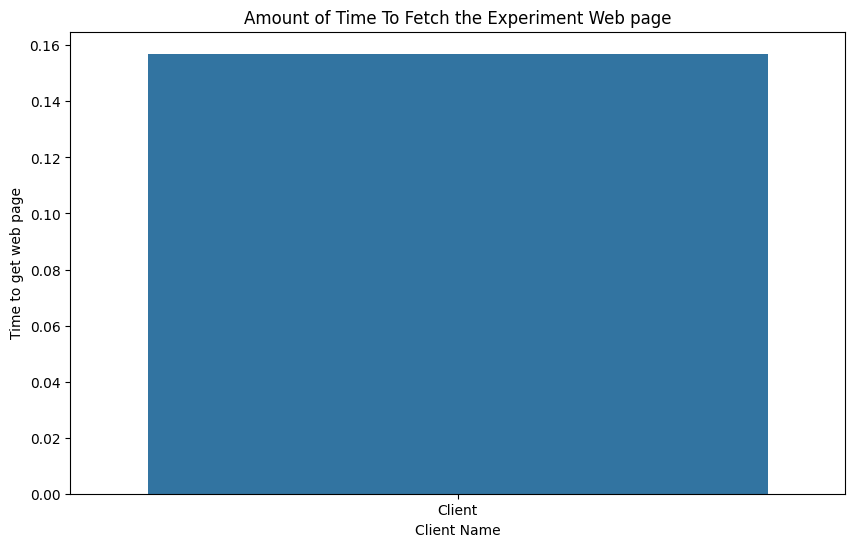

In [6]:
# Ensure the image is large enough
plt.figure(figsize=(10, 6))

# Plot a simple bar chart with each client along the x-axis
# and the time it took along the y-axix
fig = sns.barplot(data=dropped, x="client", y="time")

# Enhance the output image with a title and better axis labels
plt.xlabel("Client Name")
plt.ylabel("Time to get web page")
plt.title("Amount of Time To Fetch the Experiment Web page")

# Show the image
plt.show()